# Convolutional Neural Network

This is a guide copied from the deeplizard youtube video on preparing images and creating a CNN model. 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
%matplotlib inline

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs Available: ', len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


### Prepare the train, validation, and test sets

In [3]:
os.chdir('D:/dogs-vs-cats')
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')
    
    os.chdir('train/')
    for c in random.sample(glob.glob('dog*'), 500):
        shutil.move(c, '../train/dog')
    for c in random.sample(glob.glob('cat*'), 500):
        shutil.move(c, '../train/cat')
    for c in random.sample(glob.glob('dog*'), 100):
        shutil.move(c, '../valid/dog')
    for c in random.sample(glob.glob('cat*'), 100):
        shutil.move(c, '../valid/cat')
    for c in random.sample(glob.glob('dog*'), 50):
        shutil.move(c, '../test/dog')
    for c in random.sample(glob.glob('cat*'), 50):
        shutil.move(c, '../test/cat')
    os.chdir('..')

### Preprocess Images

CNN's usually need some image preprocessing, and a very popular model is called 'VGG16' so that model's preprocessing is applied to the batches. The batches are basically directory iterators that the model can use.

In [4]:
train_path = 'D:/dogs-vs-cats/train'
valid_path = 'D:/dogs-vs-cats/valid'
test_path  = 'D:/dogs-vs-cats/test'

In [7]:
train_batches = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(
    directory = train_path, 
    target_size = (244, 244), 
    classes = ['cat', 'dog'], 
    batch_size = 10
)

valid_batches = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(
    directory = valid_path, 
    target_size = (244, 244), 
    classes = ['cat', 'dog'], 
    batch_size = 10
)

test_batches = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(
    directory = test_path, 
    target_size = (244, 244), 
    classes = ['cat', 'dog'], 
    batch_size = 10,
    shuffle = False
)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [9]:
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n  == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [10]:
imgs, labels = next(train_batches)

In [15]:
# This function will plot images in the form of a grid with 1 row and 10 columns where images are placed in a single row
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize = (20, 20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

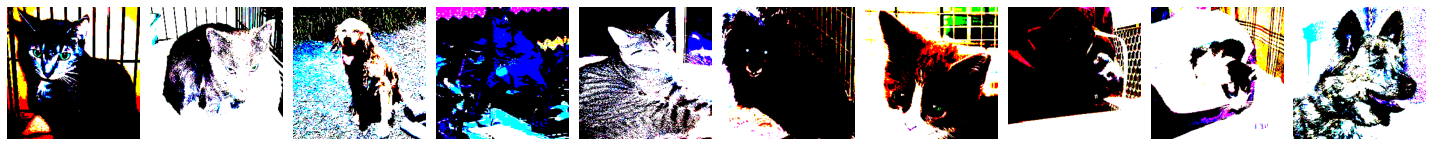

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [16]:
plotImages(imgs)
print(labels)

The model can also use `binary_crossentropy` for the loss and the dense layer to a single node with a `sigmoid` activation function.

In [18]:
model = Sequential([
    Conv2D(filters = 32, # arbitrary 
        kernel_size = (3, 3), # very common for image data
        activation = 'relu', 
        padding = 'same', # removes padding from images for convolution
        input_shape = (244, 244, 3)), # implicit input layer, target_size and color_channels
    MaxPool2D(pool_size = (2, 2), 
              strides = 2), # this function cuts image in half
    Conv2D(filters = 64, 
           kernel_size = (3, 3), 
           activation = 'relu', 
           padding = 'same'),
    MaxPool2D(pool_size = (2, 2), 
              strides = 2),
    Flatten(),
    Dense(units = 2, # the classes
          activation = 'softmax'),
])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 244, 244, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 122, 122, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 238144)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 476290    
Total params: 495,682
Trainable params: 495,682
Non-trainable params: 0
__________________________________________________

In [25]:
model.compile(optimizer = Adam(learning_rate = 0.00008),
             loss = 'categorical_crossentropy', 
             metrics = ['accuracy'])

Normally, you specify the `y` that represents the target data. But, since this is a created batch, it has the target data incorporated.

In [26]:
model.fit(x = train_batches,
          validation_data = valid_batches, 
          epochs = 10,
          verbose = 2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 20 steps
Epoch 1/10
100/100 - 6s - loss: 0.5738 - accuracy: 0.9100 - val_loss: 3.5381 - val_accuracy: 0.6100
Epoch 2/10
100/100 - 5s - loss: 0.0225 - accuracy: 0.9960 - val_loss: 3.0751 - val_accuracy: 0.6200
Epoch 3/10
100/100 - 5s - loss: 0.1254 - accuracy: 0.9720 - val_loss: 3.6127 - val_accuracy: 0.6000
Epoch 4/10
100/100 - 5s - loss: 0.1027 - accuracy: 0.9770 - val_loss: 3.4242 - val_accuracy: 0.6400
Epoch 5/10
100/100 - 5s - loss: 0.0118 - accuracy: 0.9960 - val_loss: 3.6474 - val_accuracy: 0.6250
Epoch 6/10
100/100 - 5s - loss: 0.0298 - accuracy: 0.9950 - val_loss: 4.1872 - val_accuracy: 0.5950
Epoch 7/10
100/100 - 5s - loss: 0.1863 - accuracy: 0.9620 - val_loss: 6.0652 - val_accuracy: 0.5550
Epoch 8/10
100/100 - 5s - loss: 0.1431 - accuracy: 0.9640 - val_loss: 2.9646 - val_accuracy: 0.6350
Epoch 9/10
100/100 - 5s - loss: 0.0299 - accuracy: 0.9900 - val_loss: 2.9925 - val_accuracy: 0.6350
Epoch 1

In [ ]:
# steps_per_epoch = num in training_set / size